In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def manhattan(x1: int, y1: int, x2: int, y2: int) -> int:
    return abs(x1 - x2) + abs(y1 - y2)

def lr_proba(dist, alpha):
    if not isinstance(dist, np.ndarray):
        dist = np.array(dist, dtype=float)
    
    zero_mask = dist <= 1
    result = np.zeros_like(dist)
    result[~zero_mask] = dist[~zero_mask] ** -alpha
    return result

# Sampling offset distance

Text(0, 0.5, 'Probability')

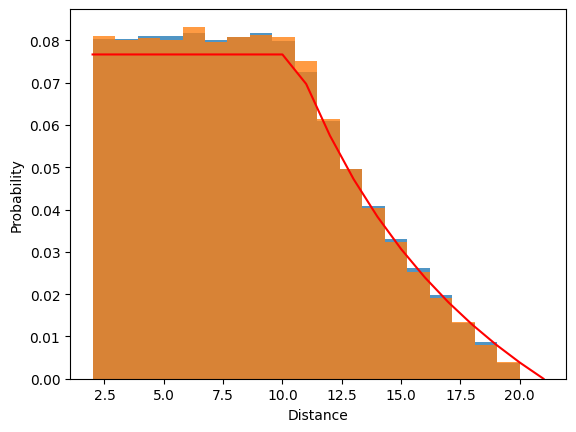

In [3]:
from scipy.stats.sampling import DiscreteAliasUrn

def num_of_distance(n,i):
    assert n % 2 == 1
    diameter = (n-1) // 2
    if i == 0:
        return 1
    if i <= diameter:
        return 4 * i
    z = 2*diameter - i+1
    return 4 * z


class ReferenceDistanceSampler:
    def __init__(self, n: int, alpha: float):
        self.n = n
        self.alpha = alpha
        proba_mtx = np.zeros((n*2+1, n*2+1))
        for i in range(n*2+1):
            for j in range(n*2+1):
                dist = manhattan(n, n, i, j)
                proba_mtx[i, j] = lr_proba(dist, alpha)
        proba_mtx /= proba_mtx.sum()
        self.probas = proba_mtx.flatten()
        self.index = np.arange(len(self.probas))

    def sample(self, num_samples: int = 1):
        indices = np.random.choice(self.index, p=self.probas, size=num_samples)
        x, y = np.unravel_index(indices, (self.n*2+1, self.n*2+1))
        x -= self.n
        y -= self.n
        return np.abs(x) + np.abs(y)
    

class MultinomialDistanceSampler:
    def __init__(self, n: int, alpha: float) -> None:
        self.n = n
        self.alpha = alpha
        self.max_dist = n*2+1
        self.values = np.arange(2, self.max_dist+1)
        self.probas = lr_proba(self.values.astype(float), alpha)
        for i in range(2, self.max_dist+1):
            self.probas[i-2] *= num_of_distance(n*2+1, i)
        self.probas /= self.probas.sum()

    def sample(self, num_samples: int = 1):
        return np.random.choice(self.values, p=self.probas, size=num_samples)
    

class AliasDistanceSampler:
    def __init__(self, n: int, alpha: float) -> None:
        self.n = n
        self.alpha = alpha
        self.max_dist = n*2+1
        self.values = np.arange(2, self.max_dist+1)
        self.probas = lr_proba(self.values.astype(float), alpha)
        for i in range(2, self.max_dist+1):
            self.probas[i-2] *= num_of_distance(n*2+1, i)
        self.probas /= self.probas.sum()
        self.alias = DiscreteAliasUrn(self.probas, urn_factor=1.0)

    def sample(self, num_samples: int = 1):
        return self.values[self.alias.rvs(num_samples)]






m = AliasDistanceSampler(10,1)
s = ReferenceDistanceSampler(10, 1)
samples = s.sample(100000)
samples2 = m.sample(100000)
plt.hist(samples, bins=len(set(samples)), density=True, alpha=.78)
plt.hist(samples2, bins=len(set(samples2)), density=True, alpha=.78)
plt.plot(m.values, m.probas, 'r')
plt.xlabel('Distance')
plt.ylabel('Probability')

In [ ]:
m.

In [5]:
class ReferenceDistanceIndex2Offset:

    def __init__(self, n: int) -> None:
        self.n = n
        self.distances = np.zeros((n*2+1, n*2+1))
        for i in range(n*2+1):
            for j in range(n*2+1):
                dist = manhattan(n, n, i, j)
                self.distances[i, j] = dist

    def sample(self, distance: int, index: int):
        x,y = (self.distances == distance).nonzero()
        x -= self.n
        y -= self.n
        return x[index], y[index]
    

class FastDistanceIndex2Offset:

    def __init__(self, n: int) -> None:
        self.n = n

    def sample(self, distance: int, index: int):
        # TODO: support arrays
        n = num_of_distance(self.n*2+1, distance)
        assert index < n, f'Index {index} is out of bounds for distance {distance}'
        fields_per_side = n // 4
        field_idx = index // fields_per_side
        remainder = index % fields_per_side
        
        min_x = max(1, distance - self.n)
        dx = min_x + remainder
        dy = distance - dx
        if field_idx == 0:
            return dx, dy
        elif field_idx == 1:
            return dy, -dx
        elif field_idx == 2:
            return -dx, -dy
        else:
            return -dy, dx



k = 6
n = 5
q = FastDistanceIndex2Offset(n)
qref = ReferenceDistanceIndex2Offset(n)
indices = [q.sample(k, i) for i in range(num_of_distance(n*2+1, k))]
indices2 = [qref.sample(k, i) for i in range(num_of_distance(n*2+1, k))]
print(indices)
print(indices2)
assert set(indices) == set(indices2)

[(1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (5, -1), (4, -2), (3, -3), (2, -4), (1, -5), (-1, -5), (-2, -4), (-3, -3), (-4, -2), (-5, -1), (-5, 1), (-4, 2), (-3, 3), (-2, 4), (-1, 5)]
[(-5, -1), (-5, 1), (-4, -2), (-4, 2), (-3, -3), (-3, 3), (-2, -4), (-2, 4), (-1, -5), (-1, 5), (1, -5), (1, 5), (2, -4), (2, 4), (3, -3), (3, 3), (4, -2), (4, 2), (5, -1), (5, 1)]


# Sampling offset

In [28]:
class ReferenceOffsetSampler:

    def __init__(self, n: int, alpha: float) -> None:
        self.n = n
        self.alpha = alpha
        proba_mtx = np.zeros((n*2+1, n*2+1))
        for i in range(n*2+1):
            for j in range(n*2+1):
                dist = manhattan(n, n, i, j)
                proba_mtx[i, j] = lr_proba(dist, alpha)
        # unnormalized probabilities
        self.uprob = proba_mtx

    def _proba_view(self, gx: int, gy: int) -> np.ndarray:
        assert 0 <= gx < self.n
        assert 0 <= gy < self.n
        sx = self.n - gx
        sy = self.n - gy
        return self.uprob[sx:sx+self.n, sy:sy+self.n].copy()
    
    def sample(self, gx: int, gy: int, num_samples: int = 1):
        proba = self._proba_view(gx, gy)
        proba /= proba.sum()
        indices = np.random.choice(np.arange(self.n*self.n), p=proba.flatten(), size=num_samples)
        x, y = np.unravel_index(indices, (self.n, self.n))
        return x, y
    

class UnconstrainedOffsetSampler:
    def __init__(self, n: int, alpha: float) -> None:
        self.n = n
        self.alpha = alpha
        self.distance_sampler = AliasDistanceSampler(n, alpha)
        self.dist2offset = FastDistanceIndex2Offset(n)

    def _sample_offset_for_distance(self, distance: int):
        n = num_of_distance(self.n*2+1, distance)
        index = np.random.randint(n)
        return self.dist2offset.sample(distance, index)

    def sample(self, num_samples: int = 1):
        distances = self.distance_sampler.sample(num_samples)
        return self._sample_offset_for_distance(distances)

class RejectionOffsetSampler:

    def __init__(self, n: int, alpha: float) -> None:
        self.n = n
        self.alpha = alpha
        self.distance_sampler = AliasDistanceSampler(n, alpha)
        self.dist2offset = FastDistanceIndex2Offset(n)

    def _sample_offset_for_distance(self, distance: int):
        n = num_of_distance(self.n*2+1, distance)
        index = np.random.randint(n)
        return self.dist2offset.sample(distance, index)

    def sample(self, gx: int, gy: int, num_samples: int = 1):
        samples = []
        while len(samples) < num_samples:
            distance = self.distance_sampler.sample(num_samples)
            for d in distance:
                x, y = self._sample_offset_for_distance(d)
                x += gx
                y += gy
                if 0 <= x < self.n and 0 <= y < self.n:
                    samples.append((x, y))
        x,y = zip(*samples)
        return np.array(x), np.array(y)
    
q = UnconstrainedOffsetSampler(11, 1)

q.sample(1)

(array([0]), array([3]))

# Putting everything together

In [44]:
from tqdm import tqdm
class Navigator:

    def __init__(self, offset_sampler: ReferenceOffsetSampler) -> None:
        self.os = offset_sampler

    def _step(self, cx: int, cy: int, tx: int, ty: int):
        lx, ly = self.os.sample(cx, cy)
        lx, ly = lx[0], ly[0]
        long_range_distance = manhattan(lx, ly, tx, ty)
        short_range_distance = manhattan(cx, cy, tx, ty) - 1
        if long_range_distance < short_range_distance:
            return lx, ly
        else:
            if cx < tx:
                return cx + 1, cy
            elif cx > tx:
                return cx - 1, cy
            elif cy < ty:
                return cx, cy + 1
            else:
                return cx, cy - 1

    def navigate(self, cx: int, cy: int, tx: int, ty: int):
        assert 0 <= cx < self.os.n
        assert 0 <= cy < self.os.n
        assert 0 <= tx < self.os.n
        assert 0 <= ty < self.os.n

        path = []
        while cx != tx or cy != ty:
            cx, cy = self._step(cx, cy, tx, ty)
            path.append((cx, cy))
        return path
    

class ToroidNavigator:

    def __init__(self, n: int, offset_sampler: ReferenceOffsetSampler) -> None:
        self.n = n
        self.os = offset_sampler

    def _step(self, tx: int, ty: int):
        lx, ly = self.os.sample()
        lx, ly = lx[0], ly[0]
        long_range_distance = manhattan(lx, ly, tx, ty)
        current_distance = manhattan(cx, cy, tx, ty) - 1
        if long_range_distance < current_distance:
            return tx - lx, ty - ly
        else:
            if 0 < tx:
                return tx-1, ty
            elif tx < 0:
                return tx + 1, ty
            elif 0 < ty:
                return tx, ty - 1
            else:
                return tx, ty + 1
            
    def navigate(self, cx: int, cy: int, tx: int, ty: int):
        assert 0 <= cx < self.n
        assert 0 <= cy < self.n
        assert 0 <= tx < self.n
        assert 0 <= ty < self.n

        tx = tx - cx
        ty = ty - cy

        path = []
        while 0 != tx and 0 != ty:
            tx, ty = self._step(tx, ty)
            tx, ty = abs(tx), abs(ty)
            path.append((tx, ty))
        return path
    


N = 20_000


distances = {}

for alpha in np.linspace(0, 2.5, 26):
    os = RejectionOffsetSampler(N, alpha)
    nav = Navigator(os)
    #os = UnconstrainedOffsetSampler(N, alpha)
    #nav = ToroidNavigator(N, os)

    distances[alpha] = []
    for _ in tqdm(range(1000), total=1000):
        cx, cy, tx, ty = np.random.randint(N, size=4)
        distances[alpha].append(len(nav.navigate(cx, cy, tx, ty)))

 14%|█▍        | 140/1000 [00:04<00:29, 29.48it/s]


KeyboardInterrupt: 

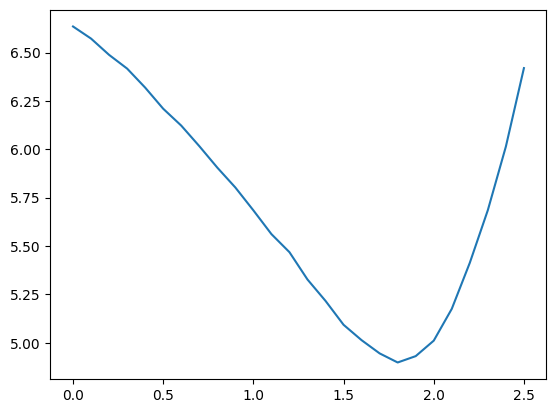

In [42]:
import matplotlib.pyplot as plt

plt.plot(distances.keys(), [np.log(np.mean(distances[alpha])) for alpha in distances.keys()])

# Alias sampling

In [94]:
from scipy.stats.sampling import DiscreteAliasUrn

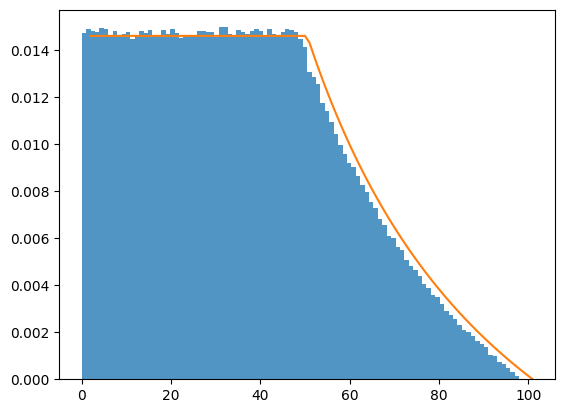

In [111]:

d_ = MultinomialDistanceSampler(50, 1)
d = DiscreteAliasUrn(d_.probas)
samples = d.rvs(1000000)
vals = np.arange(1, 101)
plt.hist(samples, bins=len(d_.values)-1, density=True, alpha=.78)
plt.plot(d_.values, d_.probas)

In [112]:
%%timeit
d_.sample()

11.6 µs ± 50.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [113]:
%%timeit
d.rvs(1)

4.31 µs ± 59.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [114]:
d_ = MultinomialDistanceSampler(50_000, 1)

In [116]:
%%timeit
d = DiscreteAliasUrn(d_.probas)

590 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
